# **Exploratory Data Analysis**

## **Initial Analysis**

In [ ]:
!gdown 1tuG_APpTipfSU67j_jSPCufYQUFUdQWp

Downloading...
From: https://drive.google.com/uc?id=1tuG_APpTipfSU67j_jSPCufYQUFUdQWp
To: /content/ola_driver_scaler.csv
100% 1.13M/1.13M [00:00<00:00, 88.1MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, recall_score, precision_score, f1_score
from xgboost import XGBClassifier

In [ ]:
df = pd.read_csv('/content/ola_driver_scaler.csv')
backup = df.copy()
df.head(5)

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [ ]:
print(f'Number of rows in dataset: {df.shape[0]}')
print(f'Number of columns in dataset: {df.shape[1]}')

Number of rows in dataset: 19104
Number of columns in dataset: 14


In [ ]:
print(df['Unnamed: 0'].nunique())
# Unnamed: 0 is of no significance so we will drop it
df.drop(columns = ['Unnamed: 0'], inplace = True)

19104


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


In [ ]:
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])
df['City'] = df['City'].astype('category')
df.rename(columns={'MMM-YY': 'Date'}, inplace=True)
df1 = df.copy(deep = True)

Our first task is to find the **target** variable and also the features that could help us in affecting the target. We will consider `target` as `0` if the LastWorkingDate is `NaN` or `NaT`. This means that the driver is still working for the Ola while if the Lastworkingdate is present, it means the driver has left the company and we will term it as `1`. This will define the churn of the driver.

In [ ]:
first =  (df1.groupby('Driver_ID').agg({'LastWorkingDate':'last'})['LastWorkingDate'].isna()).reset_index()
first['LastWorkingDate'].replace({True:1,False:0},inplace=True)
first.rename(columns={'LastWorkingDate':'target'},inplace=True)
first.head()

,Driver_ID,target
0,1,0
1,2,1
2,4,0
3,5,0
4,6,1


One of the reasons a driver leaves the company could be promotion so we will check that using quaterly rating.

In [ ]:
Qr1 = df1.groupby('Driver_ID').agg({'Quarterly Rating': 'first'})
Qr2 = df1.groupby('Driver_ID').agg({'Quarterly Rating': 'last'})
first = first.merge(Qr1, on = 'Driver_ID')
first = first.merge(Qr2, on = 'Driver_ID')
first['Promotion'] = np.where(first['Quarterly Rating_x'] == first['Quarterly Rating_y'], 0, 1)

Another reason could be no raise in the Salary of employee.

In [ ]:
incm1 = df1.groupby('Driver_ID').agg({'Income': 'first'})
incm2 = df1.groupby('Driver_ID').agg({'Income': 'last'})
first = first.merge(incm1, on = 'Driver_ID')
first = first.merge(incm2, on = 'Driver_ID')
first['Raise'] = np.where(first['Income_x'] == first['Income_y'], 0, 1)
first = first[['Driver_ID', 'target', 'Promotion', 'Raise']]

In [ ]:
#Our first task to create a target variable.
functions = {
    'Date': 'count',
    'Driver_ID': 'first',
    'Age': 'max',
    'Gender': 'last',
    'City': 'last',
    'Education_Level': 'last',
    'Income': 'mean',
    'Dateofjoining': 'first',
    'LastWorkingDate': 'last',
    'Joining Designation':'last',
    'Grade': 'last',
    'Total Business Value': 'sum',
    'Quarterly Rating': 'first'
}

df = df.groupby('Driver_ID').aggregate(functions)

Here we are grouping all the features of driver and choosing that value of feature that could be the most useful in predicting the outcome.

In [ ]:
df.rename(columns = {'Date': 'No. of Reportings'}, inplace = True)
df.reset_index(drop = True, inplace = True)
df = df.merge(first, on = 'Driver_ID')
df.head()

,No. of Reportings,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,target,Promotion,Raise
0,3,1,28.0,0.0,C23,2,57387.0,2018-12-24,2019-03-11,1,1,1715580,2,0,0,0
1,2,2,31.0,0.0,C7,2,67016.0,2020-11-06,NaT,2,2,0,1,1,0,0
2,5,4,43.0,0.0,C13,2,65603.0,2019-12-07,2020-04-27,2,2,350000,1,0,0,0
3,3,5,29.0,0.0,C9,0,46368.0,2019-01-09,2019-03-07,1,1,120360,1,0,0,0
4,5,6,31.0,1.0,C11,1,78728.0,2020-07-31,NaT,3,3,1265000,1,1,1,0


Here we merge all the important columns and we get the dataset required.

## **Univariate Analysis**

First we do our graphical analysis on contineous columns of the dataset.

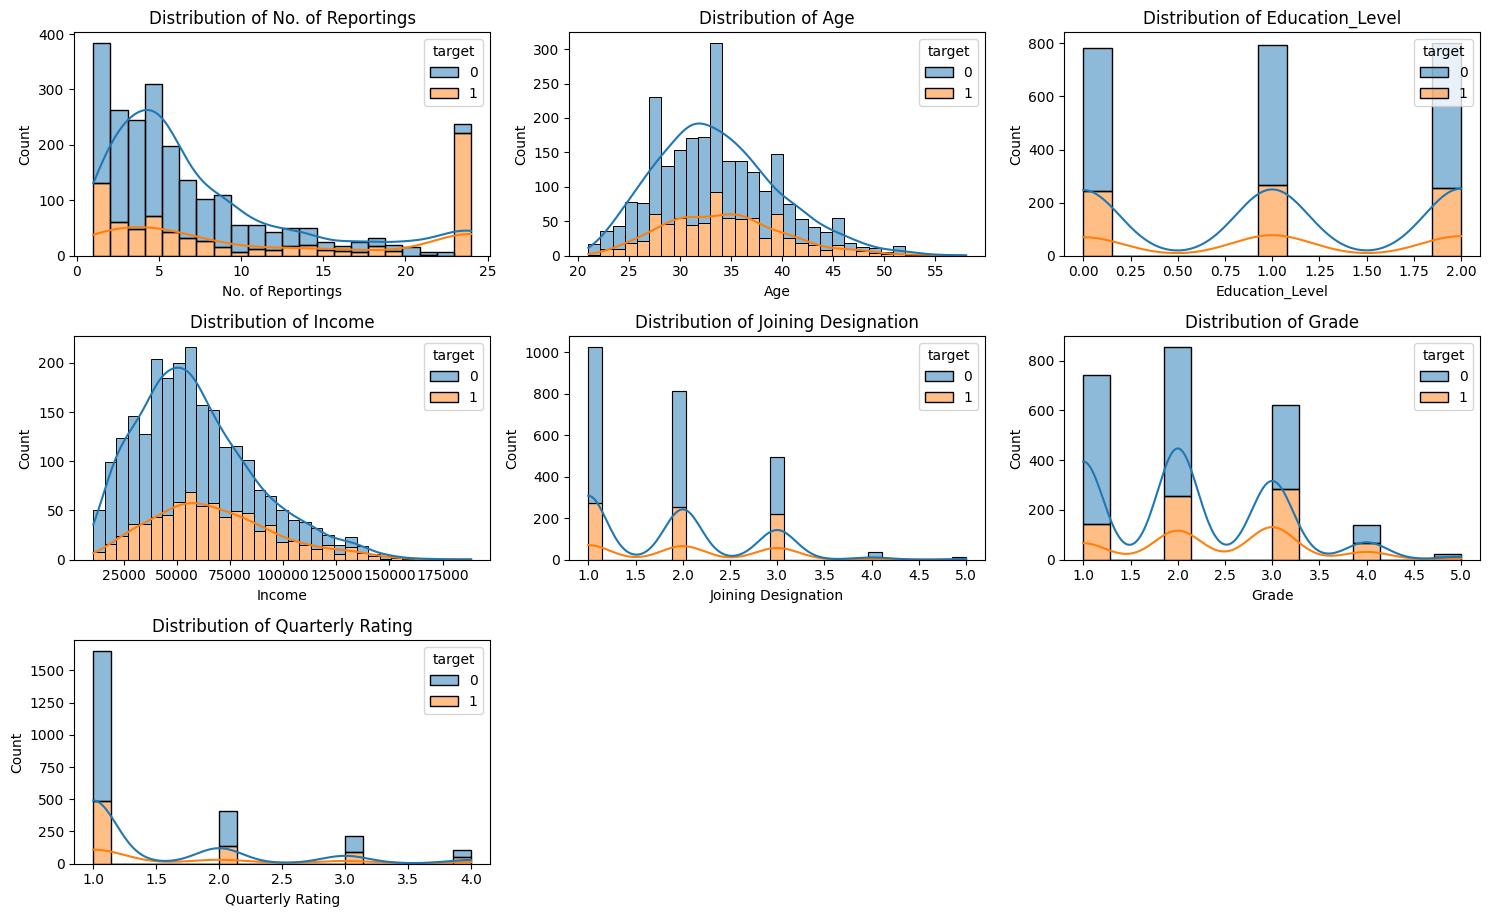

In [ ]:
columns = ['No. of Reportings', 'Age', 'Education_Level', 'Income', 'Joining Designation', 'Grade', 'Quarterly Rating']
fig = plt.figure(figsize = (15,21))
i = 1
for col in columns:
  ax = plt.subplot(7,3,i)
  sns.histplot(x = col, data = df, kde = True, hue = 'target', multiple = 'stack')
  plt.title(f'Distribution of {col}')
  i+=1

plt.tight_layout()
plt.show()

**Observations :**
- Number of reportings per month is much higher for drivers who stayed with the company rather than who left the company. This could mean that the driver who plans to leave the company could not show up frequently per month
- Most of the drivers who work at the company are between the age of 27 and 35.
- The number of drivers distributed among education_level is nearly uniform.
- Drivers with income 30000 - 750000 are most likely to leave the company.
- The joining designation is majorly between 1 and 3 for both staying and leaving drivers.
- The quaterly rating is mostly 1 for both leaving and staying.

Now we do analysis on two important categorical columns: *Gender* and *City*. We have used **Count Plot** for this work.
- Male : 0
- Female: 1

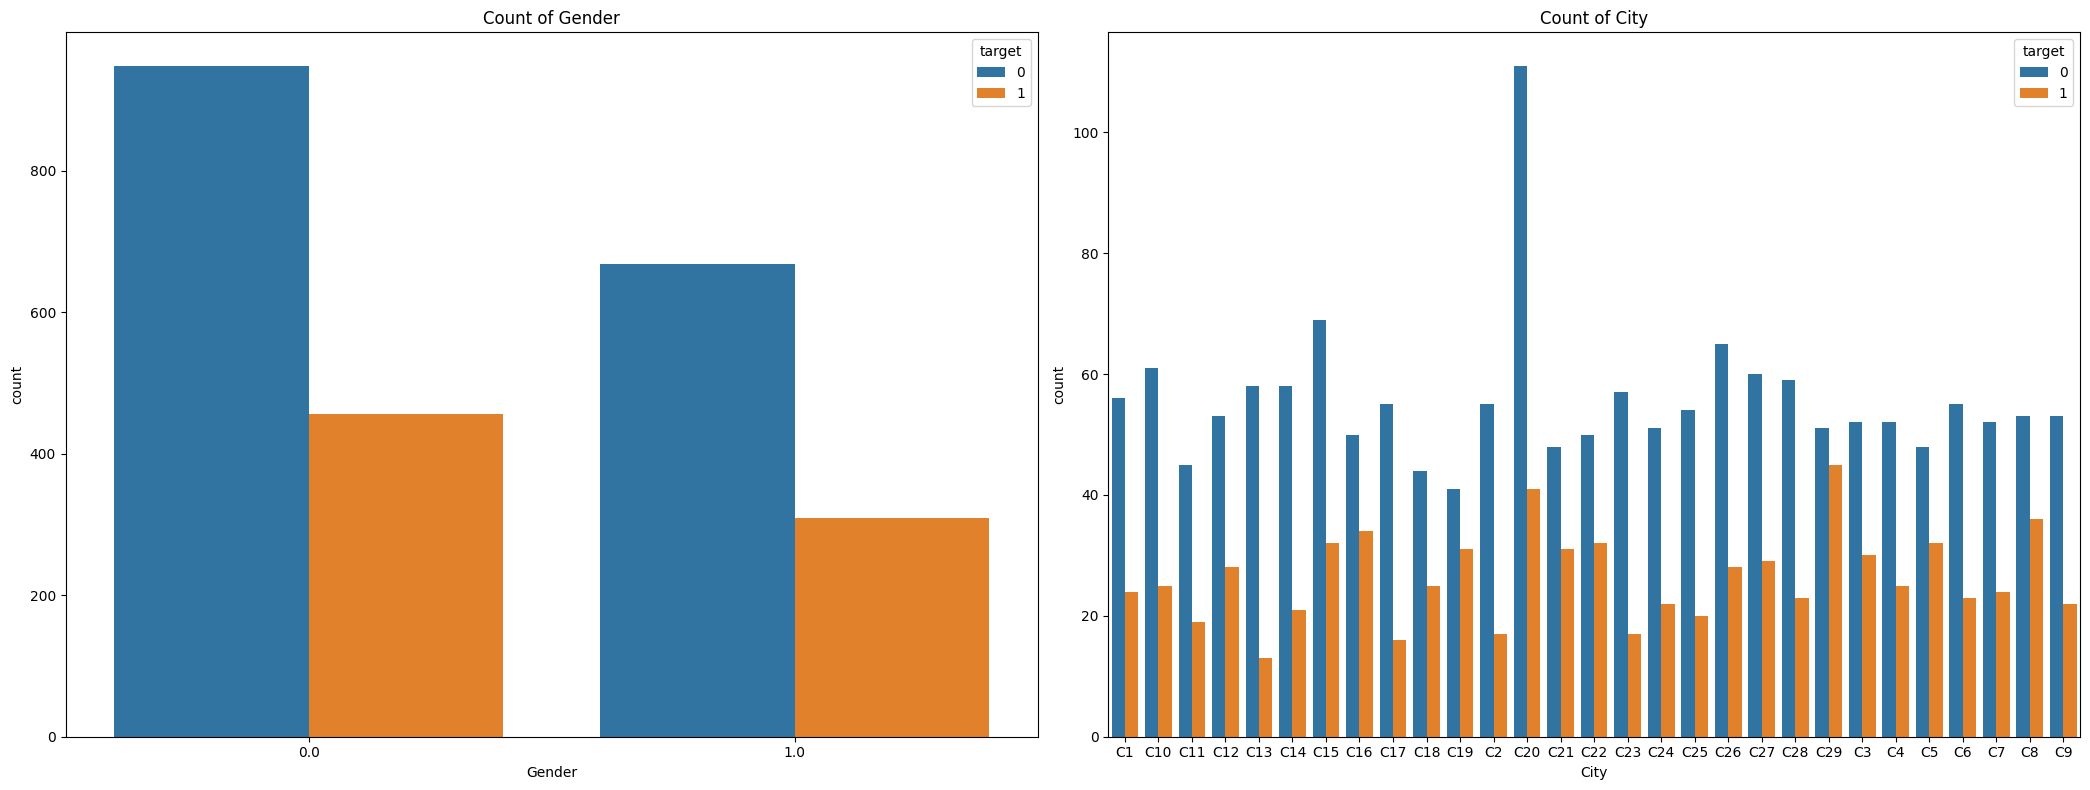

In [ ]:
cat_cols = ['Gender', 'City']
fig = plt.figure(figsize = (21,8))
i = 1
for col in cat_cols:
  ax = plt.subplot(1,2,i)
  sns.countplot(x = col, data = df, hue = 'target')
  plt.title(f'Count of {col}')
  i+=1

plt.tight_layout()
plt.show()

**Observations :**
- In case of gender, most drivers working are male and most drivers leaving are also male.
- In case of cities, most number of drivers working are from city `C20` and most drivers leaving the company are from `C29`

## **Bivariate Analysis**

We pick Age and Gender for the first graph.

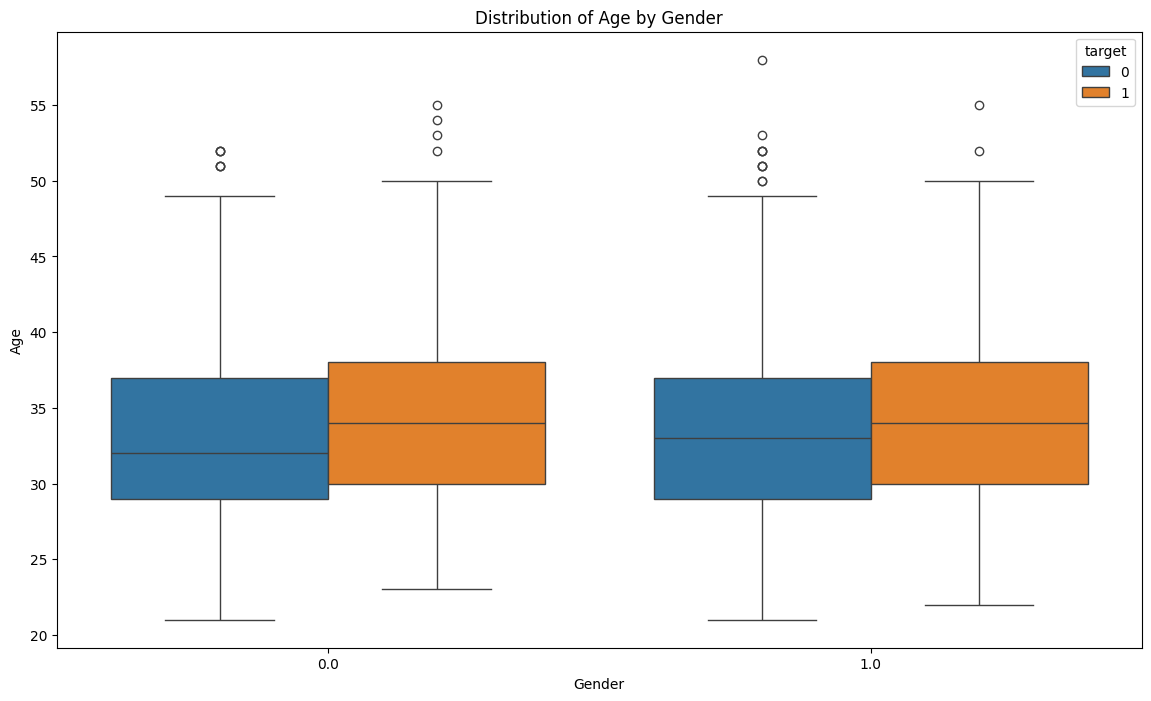

In [ ]:
#Age and Gender
plt.figure(figsize = (14,8))
sns.boxplot(x = 'Gender', y = 'Age', data = df, hue = 'target')
plt.title('Distribution of Age by Gender')
plt.show()

**Observations :**
- In case of both male and female, the median age of leaving the company is around 34.
- There is too much similarity between male and female that it is difficult to derive any insight on basis of gender alone.

We next pick Joining Designation and Grade

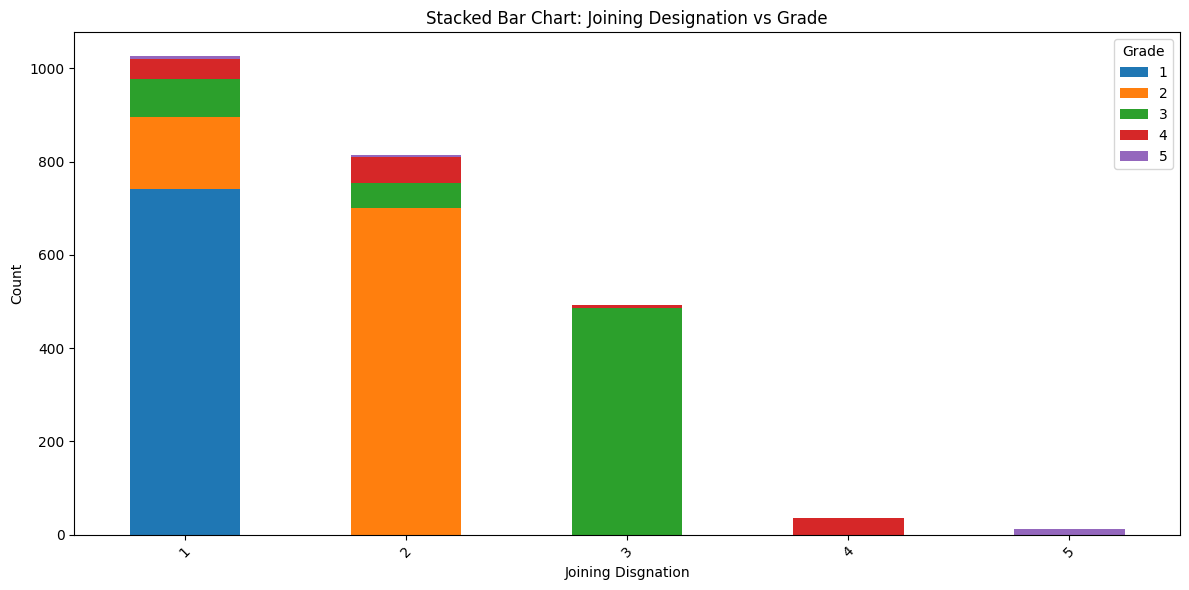

In [ ]:
#Joining Designation and Grade
crosstab_result = pd.crosstab(df['Joining Designation'], df['Grade'])
crosstab_result.plot(kind = 'bar', stacked = True, figsize = (12,6))
plt.title('Stacked Bar Chart: Joining Designation vs Grade')
plt.xlabel('Joining Disgnation')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

**Observations :**
- We notice that there is not much difference between the joining designation and thre current designation of the drivers. This is particularly True for drivers who joined at higher designation.
- The lack of promotion could be one reason why drivers leave Ola

We next pick income and Age. Since this is contineous vs contineous we choose a lineplot.

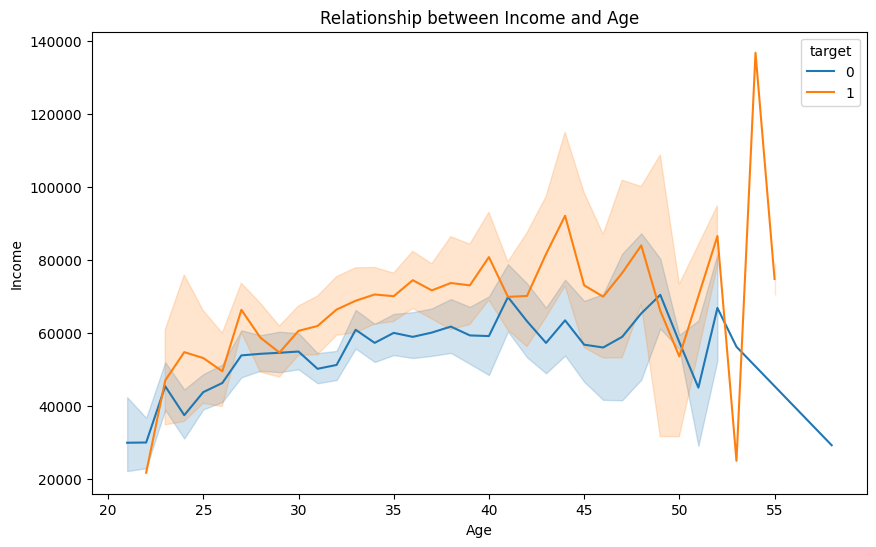

In [ ]:
plt.figure(figsize = (10,6))
sns.lineplot(x = 'Age', y = 'Income', data = df, hue = 'target')
plt.title('Relationship between Income and Age')
plt.show()

**Observations :**
- Drivers after the age of 50 leave the company in droves.
- For the rest of the graph, the pattern is same for all ages.

Next we check Age and Business Value

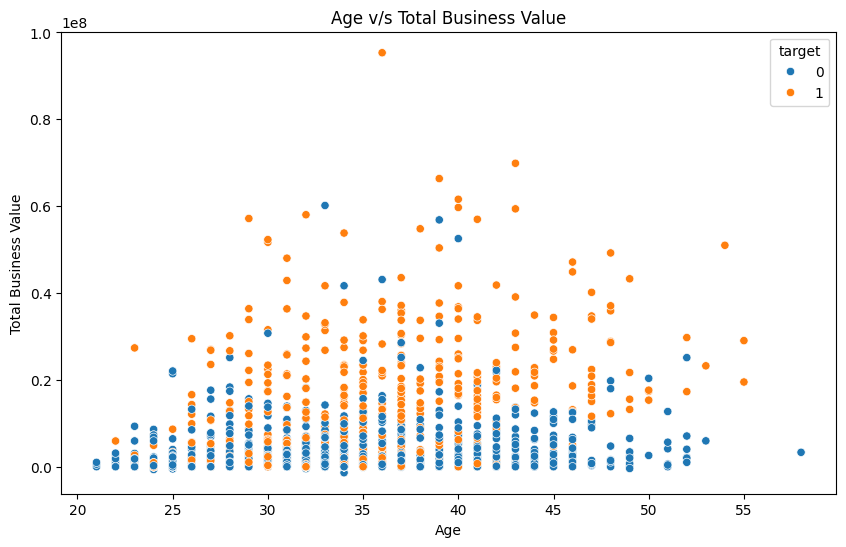

In [ ]:
plt.figure(figsize = (10,6))
sns.scatterplot(x = 'Age', y = 'Total Business Value', hue = 'target', data = df)
plt.title('Age v/s Total Business Value')
plt.show()

**Observations  :**
- We note that a lot of high Business value drivers arr leaving between the age of 30 and 45. Company should look into the matter as to why this is happening and how it can be reversed.
- Because we cannot afford to loose such high value drivers

## **Multivariate Analysis**

Now we will plot a heatmap to draw some insights about how numerical features affect each other.

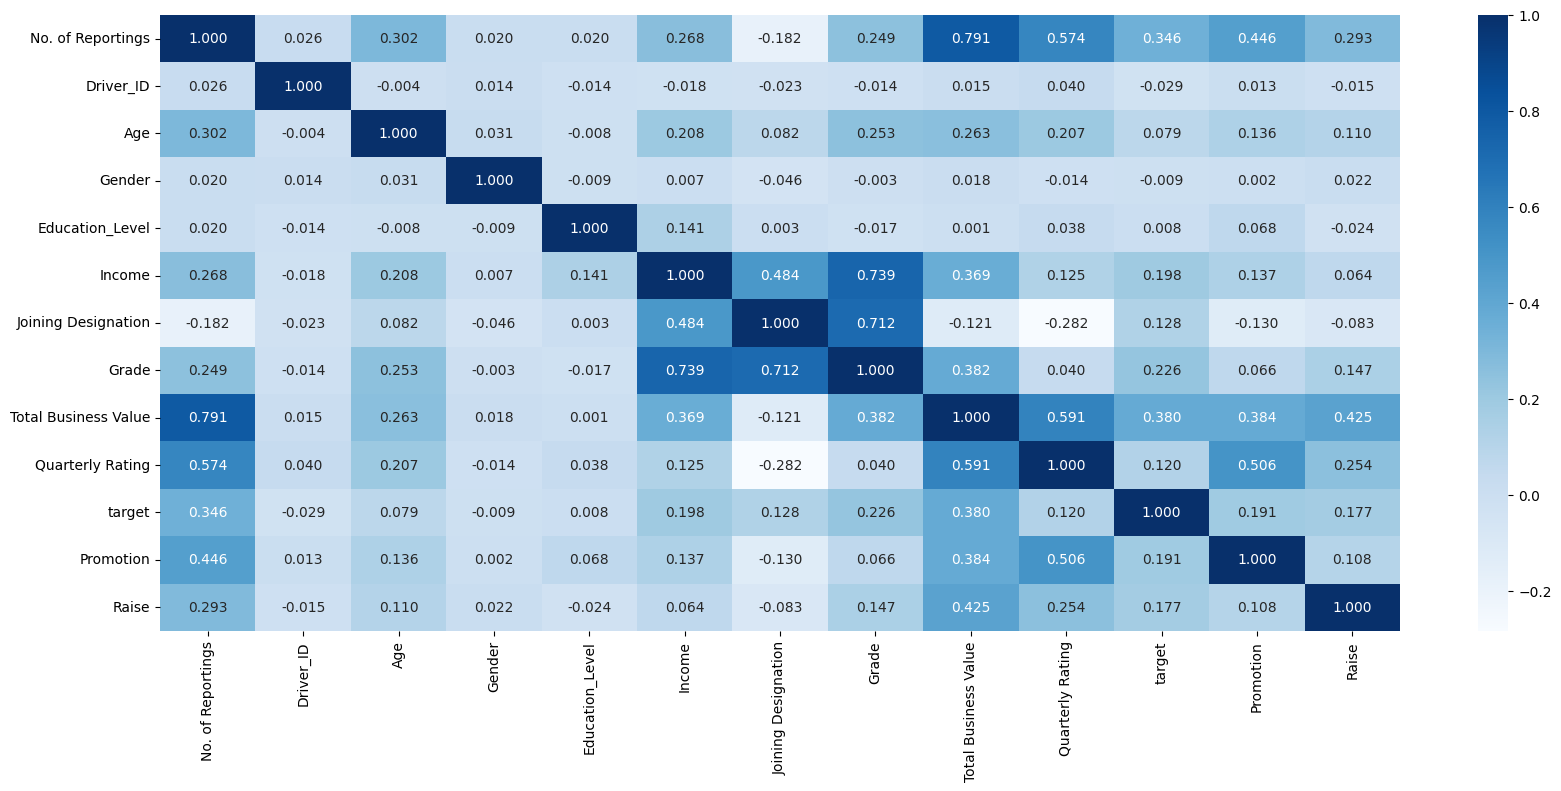

In [ ]:
numeric_df = df.select_dtypes(include = ['int64', 'float64'])
corr = numeric_df.corr()
plt.figure(figsize = (20,8))
sns.heatmap(corr, annot = True, fmt=".3f", cmap = 'Blues')
plt.show()

**Observations :**
- With respect to the target label, we notice that it is strongly correlated to `Total Business Value` and `Grade` of a driver.
- `Gender` and `education level` have negligible impact on the target.
- Target is also dependent on number of reportings of driver per month

# **Data Preprocessing**

## **Duplicated Value Check**

In [ ]:
df[df.duplicated()]

,No. of Reportings,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,target,Promotion,Raise


**Observations :** There are no duplicate values in the dataset

## **Missing Value Treatment**

In [ ]:
df.isnull().sum()

,0
No. of Reportings,0
Driver_ID,0
Age,0
Gender,0
City,0
Education_Level,0
Income,0
Dateofjoining,0
LastWorkingDate,765
Joining Designation,0


Here we find out that LastWorkingDate has 765 Null values. Since, LastWorkingDate is not numeric, we will not be able to use imputer so we will simple replace the null with median date.

## **Outlier Treatment**

We will not check for outliers in contineous columns of the dataset.

In [ ]:
numerical_columns = df.select_dtypes(include = ['int64', 'float64']).columns.tolist()

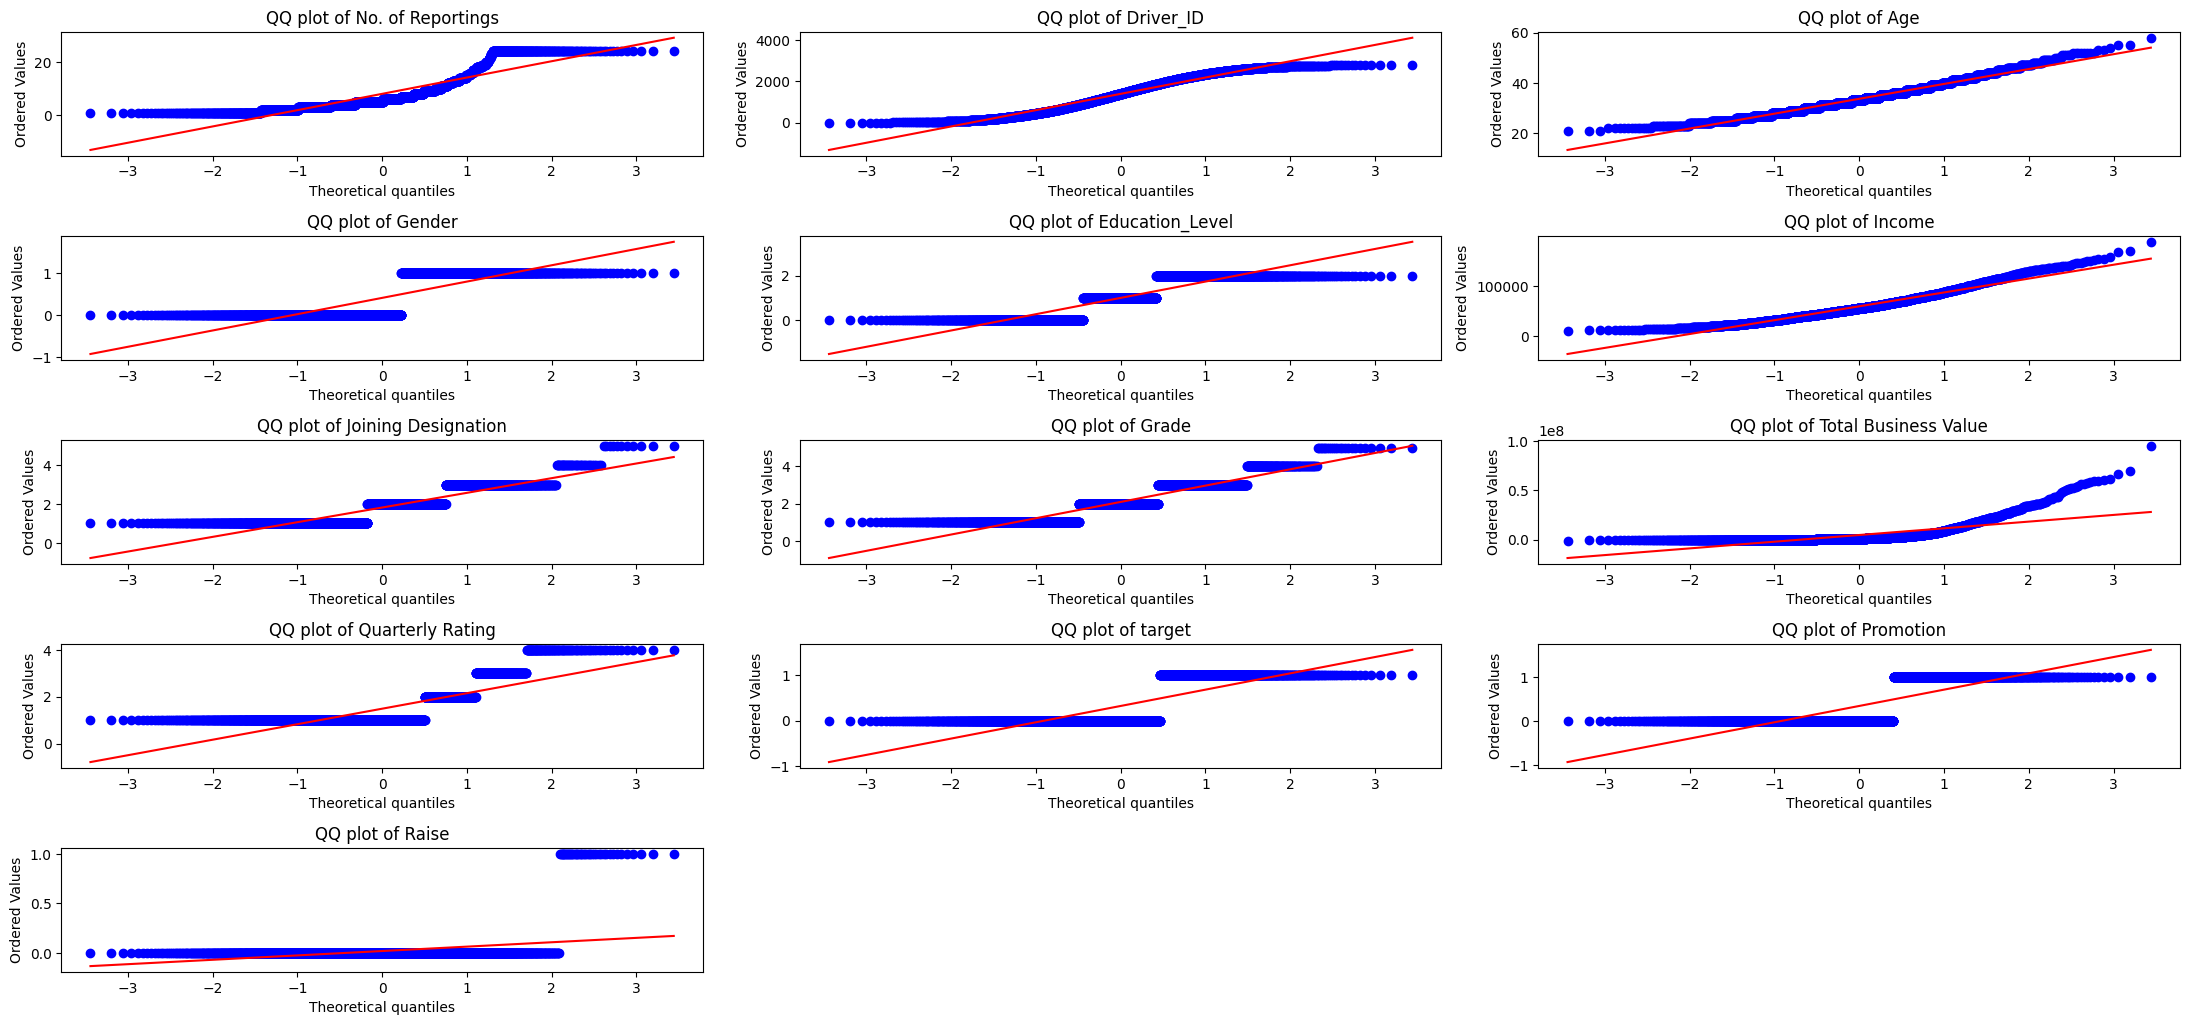

In [ ]:
plt.figure(figsize = (22,14))
i = 1
for col in numerical_columns:
  ax = plt.subplot(7,3,i)
  stats.probplot(df[col], dist = 'norm', plot = plt)
  plt.title(f'QQ plot of {col}')
  i+=1
plt.tight_layout()
plt.show()

We have drawn a QQ-Plot for numerical columsn to see the outliers. In cases of binary classifications such as target, promotion, raise there are not much outliers. And in other, the data seems to be okay. However, we will use boxplot to better visualize the outliers.

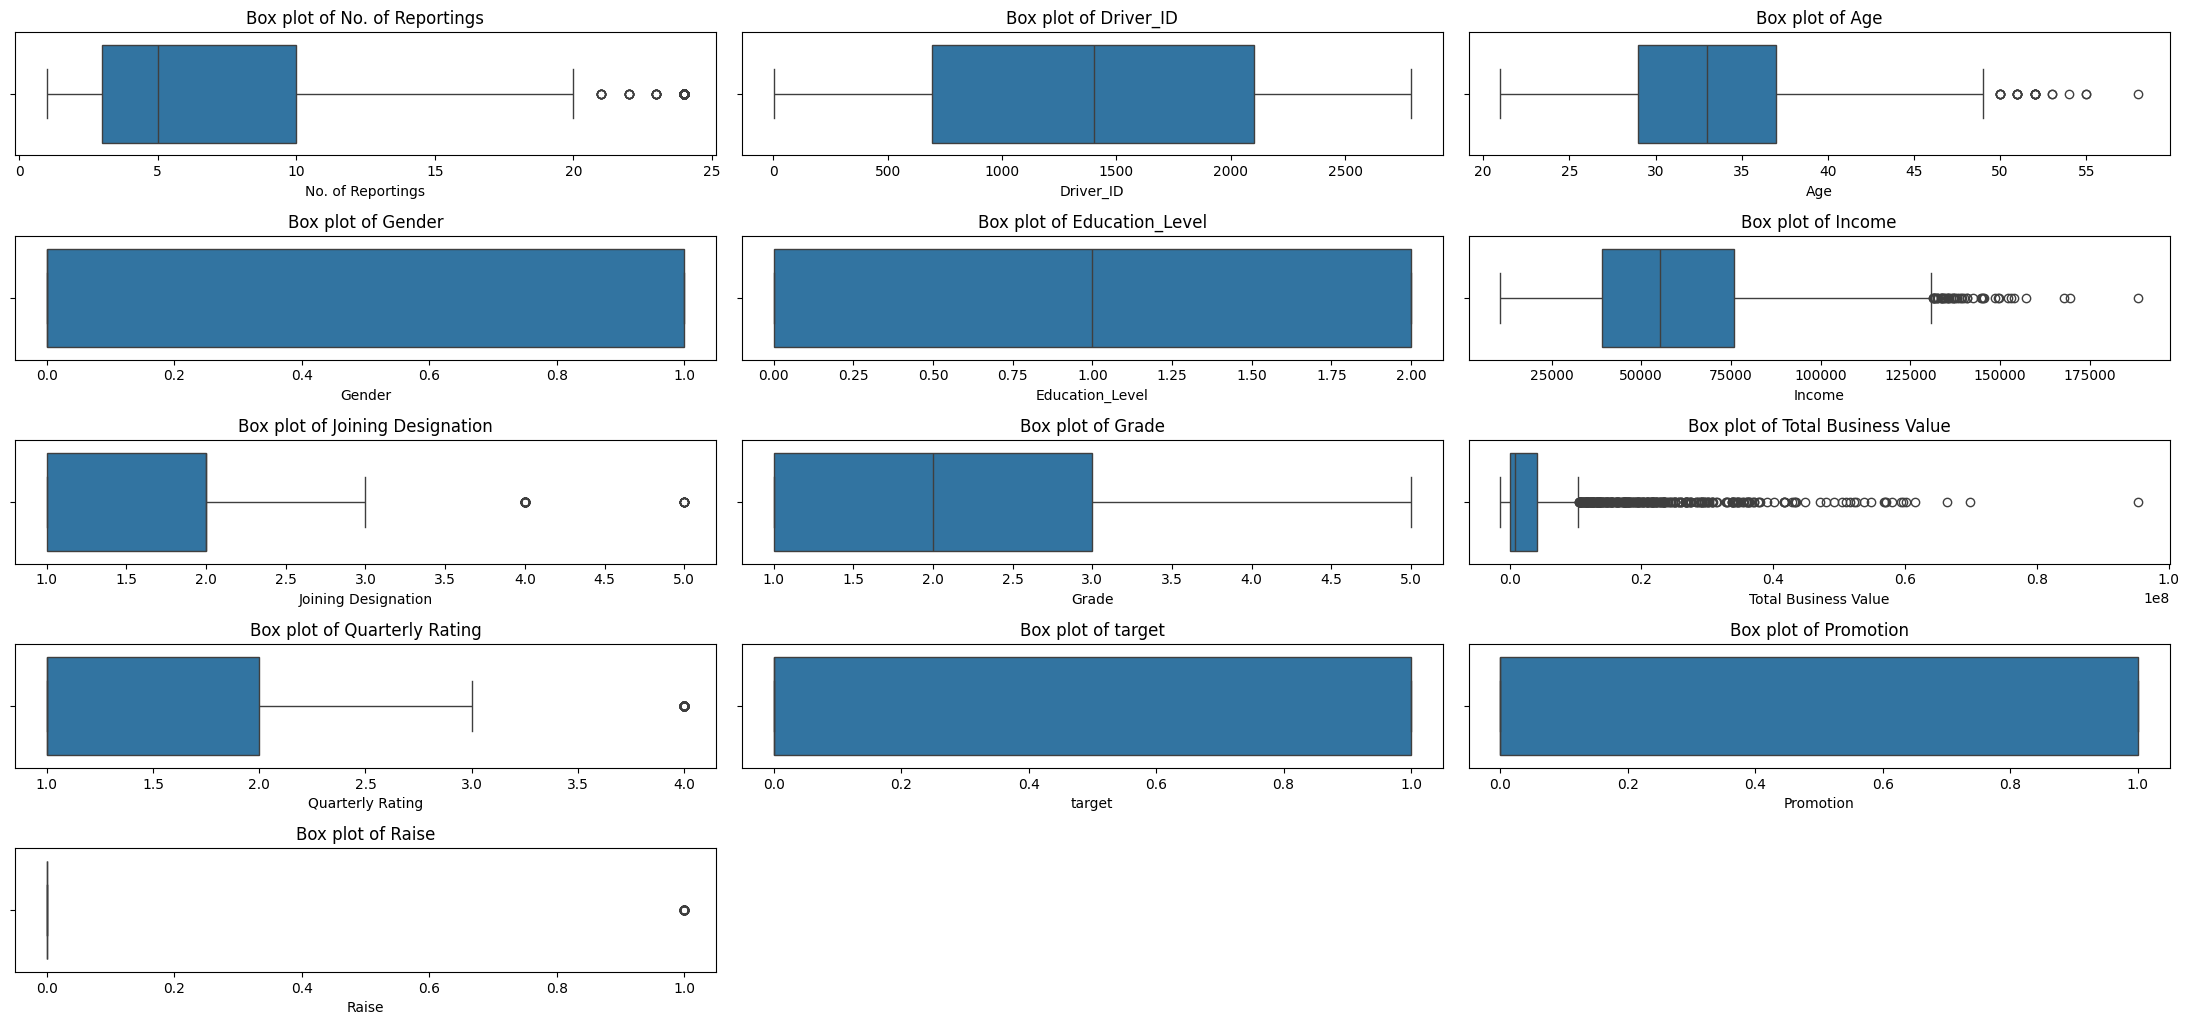

In [ ]:
plt.figure(figsize = (22,14))
i = 1
for col in numerical_columns:
  ax = plt.subplot(7,3,i)
  sns.boxplot(df[col], orient = 'h')
  plt.title(f'Box plot of {col}')
  i+=1
plt.tight_layout()
plt.show()

Here also, we notice that outliers are very few. However, the dataset it also not a very large one so, it will not make sense to remove outliers form here. Even if there is some accuracy error, we can improve it using hyperparameter tuning.

## **Feature Engineering**

First let us convert the data types of some float features to int that will be helpful.

In [ ]:
df['Age'] = df['Age'].astype(int)
df['Gender'] = df['Gender'].astype(int)
df['Income'] = df['Income'].astype(int)

Since we have created the target column, `LastWorkingDate` is not of much significant value. So we will drop this column.

In [ ]:
df.drop(columns = ['LastWorkingDate'], inplace = True)

We can also extract year and month from DateofJoining and then drop that as well. This will make out dataset move towards an ideal one for model building.

In [ ]:
df['month'] = df['Dateofjoining'].dt.month
df['year'] = df['Dateofjoining'].dt.year
df.drop(columns = ['Dateofjoining'], inplace = True)

# **Model Building**

## **Data Splitting and Encoding**

In [ ]:
X = df.drop(columns = ['target'])
y = df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
encoder = OneHotEncoder(drop = 'first', sparse_output = False)
X_train_encoded = encoder.fit_transform(X_train[['City']])
X_test_encoded = encoder.transform(X_test[['City']])
encoded_feature_names = encoder.get_feature_names_out(['City'])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)
X_train = X_train.drop(columns=['City'])
X_test = X_test.drop(columns=['City'])
X_train_final = pd.concat([X_train, X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test, X_test_encoded_df], axis=1)

## **Scaling the data and addressing class imbalance**

### Scaling the Data

In [ ]:
scaler = MinMaxScaler()

X_train_final_scaled = scaler.fit_transform(X_train_final)
X_test_final_scaled = scaler.transform(X_test_final)

In [ ]:
X_Train = pd.DataFrame(X_train_final_scaled, columns = X_train_final.columns)
X_Test = pd.DataFrame(X_test_final_scaled, columns = X_test_final.columns)

### Addressing Class Imbalance

In [ ]:
y_train.value_counts()

,count
target,
0,1289
1,615


We find out that target 0 is has 67% data while 1 has 33%. So, there is a good chance of SMOTE.

In [ ]:
smote = SMOTE(random_state = 42)
X_train_bal, y_train_bal = smote.fit_resample(X_Train, y_train)

In [ ]:
y_train_bal.value_counts()

,count
target,
1,1289
0,1289


In [ ]:
X_train_bal.shape, y_train_bal.shape

((2578, 42), (2578,))

So, the final dataset that we have to work on is:
- *X_train* = X_train_bal
- *y_train* = y_train_bal
- *X_test* = X_Test
- *y_test = y_test

## **Ensemble Learning: Bagging**

### Without Hyperparameter Tuning

We will keep track of maximum accuracy and recall value whenever we do the testing. This will help us select the model with the best required metrics. The reason why we are choosing `recall` here is because we want to minimize the False Negatives in our model. Because, it is very important for us that we do not classify a driver who will leave(1) as someone who will not leave(0) the company. This we will be very detrimental to our company. The model with the highest recall value will have the lowest False Negatives.

- Will leave the company -> 1
- Will not leave the company -> 0

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train_bal, y_train_bal)
y_pred = clf.predict(X_Test)
y_prob = clf.predict_proba(X_Test)[:,1]

In [ ]:
print(f'Accuracy score is: {accuracy_score(y_test, y_pred):.2f}')
print(f'Precision of model is: {precision_score(y_test, y_pred):.2f}')
print(f'Recall value is : {recall_score(y_test, y_pred):.2f}')
print(f'F1 score is : {f1_score(y_test, y_pred):.2f}')

Accuracy score is: 0.93
Precision of model is: 0.89
Recall value is : 0.87
F1 score is : 0.88


[[311  16]
 [ 19 131]]


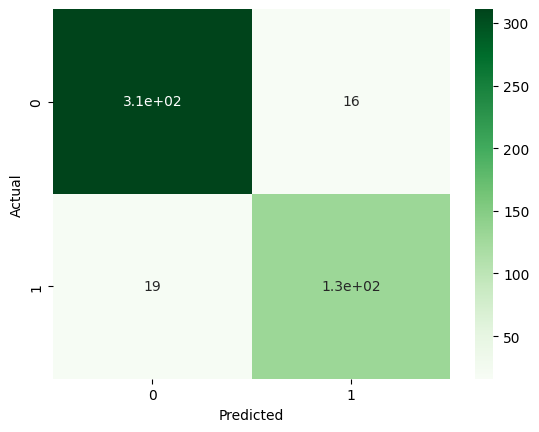

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, annot = True, cmap = 'Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       327
           1       0.89      0.87      0.88       150

    accuracy                           0.93       477
   macro avg       0.92      0.91      0.91       477
weighted avg       0.93      0.93      0.93       477



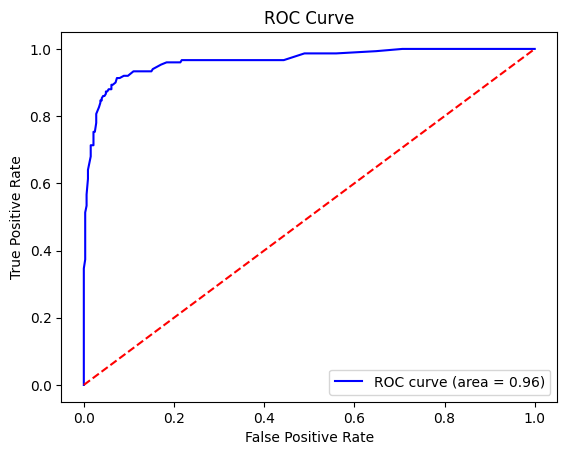

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color = 'Blue', label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color = 'Red', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Keeping track of the best accuracy, best recall and best model so far.

In [ ]:
best_accuracy = f'{accuracy_score(y_test, y_pred):.2f}'
best_recall = f'{recall_score(y_test, y_pred):.2f}'
best_model = clf
best_params = 'None'

print('Best Accuracy so far: ', best_accuracy)
print('Best Recall so far: ', best_recall)
print('Best model so far: ', best_model)
print('Best Parameters so far: ', best_params)

Best Accuracy so far:  0.93
Best Recall so far:  0.87
Best model so far:  RandomForestClassifier()
Best Parameters so far:  None


### With Hyperparameter Tuning

In [ ]:
params = {
    'n_estimators': [100, 200],
    'max_depth': [8, 12, 16],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'class_weight': ['balanced'],
}

In [ ]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X_train_bal, y_train_bal)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [ ]:
print('The best parameters of RandomForestClassifier are: ', best_params)
print('The best score of GridSearchCV is: ', best_score)

The best parameters of RandomForestClassifier are:  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
The best score of GridSearchCV is:  0.9348475953939941


In [ ]:
tuned_rf = RandomForestClassifier(bootstrap = True,
  class_weight = 'balanced',
  max_depth = 16,
  max_features = 'sqrt',
  min_samples_leaf = 1,
  min_samples_split = 5,
  n_estimators = 200,
  random_state = 42)

In [ ]:
tuned_rf.fit(X_train_bal, y_train_bal)
Y_pred_tuned = tuned_rf.predict(X_Test)
Y_prob_tuned = tuned_rf.predict_proba(X_Test)[:, 1]

In [ ]:
print(f'Accuracy score is: {accuracy_score(y_test, Y_pred_tuned):.2f}')
print(f'Precision of model is: {precision_score(y_test, Y_pred_tuned):.2f}')
print(f'Recall value is : {recall_score(y_test, Y_pred_tuned):.2f}')
print(f'F1 score is : {f1_score(y_test, Y_pred_tuned):.2f}')

Accuracy score is: 0.93
Precision of model is: 0.88
Recall value is : 0.89
F1 score is : 0.88


[[308  19]
 [ 16 134]]


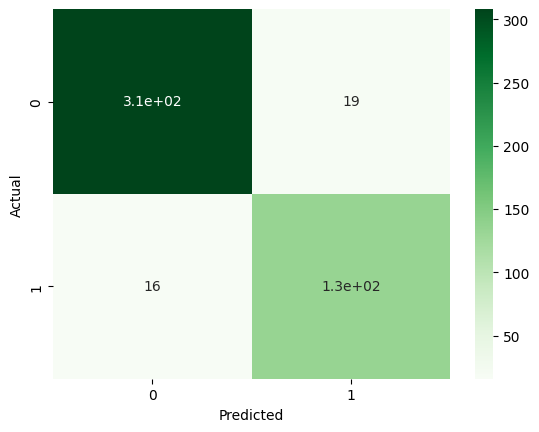

In [ ]:
cm_tuned = confusion_matrix(y_test, Y_pred_tuned)
print(cm_tuned)
sns.heatmap(cm_tuned, annot = True, cmap = 'Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
final_clf_report = classification_report(y_test, Y_pred_tuned)
print(final_clf_report)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       327
           1       0.88      0.89      0.88       150

    accuracy                           0.93       477
   macro avg       0.91      0.92      0.92       477
weighted avg       0.93      0.93      0.93       477



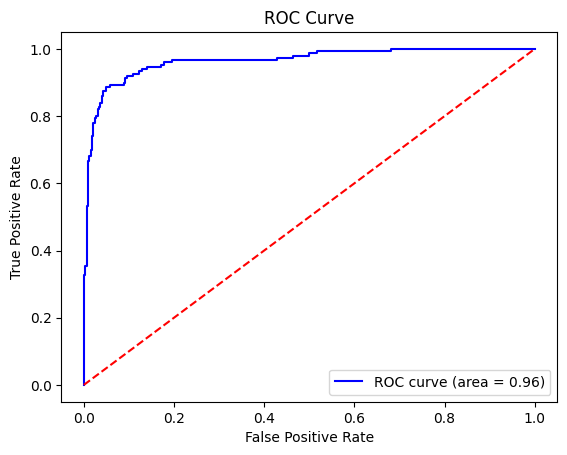

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, Y_prob_tuned)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color = 'Blue', label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color = 'Red', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Keeping track of the best metrics and model so far.

In [ ]:
prev_accuracy = best_accuracy
prev_recall = best_recall
prev_model = best_model
prev_params = 'None'

In [ ]:
if f'{accuracy_score(y_test, Y_pred_tuned):.2f}' > best_accuracy:
  best_accuracy = f'{accuracy_score(y_test, Y_pred_tuned):.2f}'
if f'{recall_score(y_test, Y_pred_tuned):.2f}' > best_recall:
  best_recall = f'{recall_score(y_test, Y_pred_tuned):.2f}'

In [ ]:
if best_accuracy != prev_accuracy or best_recall != prev_recall:
  best_model = tuned_rf
  best_params = tuned_rf.get_params()

In [ ]:
print('Best Accuracy so far: ', best_accuracy)
print('Best Recall so far: ', best_recall)
print('Best model so far: ', best_model)
print('Best Parameters so far: ', best_params)

Best Accuracy so far:  0.93
Best Recall so far:  0.89
Best model so far:  RandomForestClassifier(class_weight='balanced', max_depth=16,
                       min_samples_split=5, n_estimators=200, random_state=42)
Best Parameters so far:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## **Ensemble Learning: Boosting**

### Without Hyperparameter tuning

First we will start with **GradientBoostingClassifier** and then move on to advanced model **XGBoost**.

In [ ]:
gbm = GradientBoostingClassifier()
gbm.fit(X_train_bal, y_train_bal)
y_pred_gbm = gbm.predict(X_Test)
y_prob_gbm = gbm.predict_proba(X_Test)[:,1]

In [ ]:
print(f'Accuracy score is: {accuracy_score(y_test, y_pred_gbm):.2f}')
print(f'Precision of model is: {precision_score(y_test, y_pred_gbm):.2f}')
print(f'Recall value is : {recall_score(y_test, y_pred_gbm):.2f}')
print(f'F1 score is : {f1_score(y_test, y_pred_gbm):.2f}')

Accuracy score is: 0.93
Precision of model is: 0.87
Recall value is : 0.92
F1 score is : 0.90


[[307  20]
 [ 12 138]]


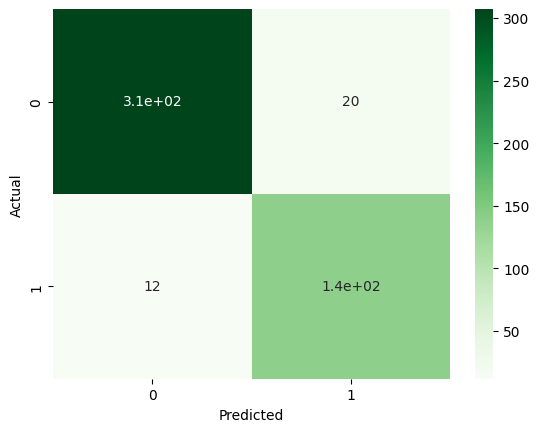

In [ ]:
cm = confusion_matrix(y_test, y_pred_gbm)
print(cm)
sns.heatmap(cm, annot = True, cmap = 'Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
gbm_report = classification_report(y_test, y_pred_gbm)
print(gbm_report)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       327
           1       0.87      0.92      0.90       150

    accuracy                           0.93       477
   macro avg       0.92      0.93      0.92       477
weighted avg       0.93      0.93      0.93       477



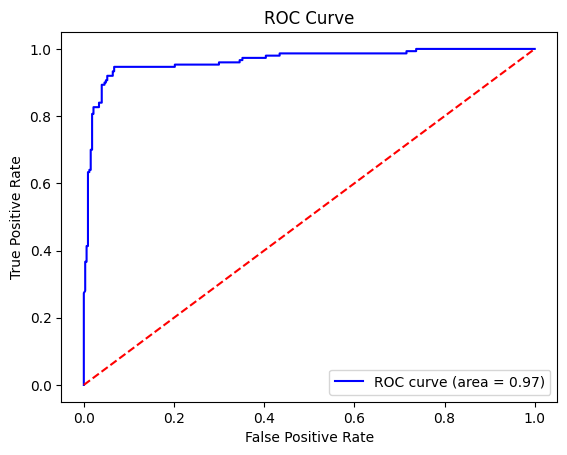

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gbm)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color = 'Blue', label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color = 'Red', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Keeping track of the best accuracy, best recall and best model so far.

In [ ]:
prev_accuracy = best_accuracy
prev_recall = best_recall
prev_model = best_model
prev_params = best_params

In [ ]:
if f'{accuracy_score(y_test, y_pred_gbm):.2f}' > best_accuracy:
  best_accuracy = f'{accuracy_score(y_test, y_pred_gbm):.2f}'
if f'{recall_score(y_test, y_pred_gbm):.2f}' > best_recall:
  best_recall = f'{recall_score(y_test, y_pred_gbm):.2f}'

In [ ]:
if best_accuracy != prev_accuracy or best_recall != prev_recall:
  best_model = gbm
  best_params = gbm.get_params()

In [ ]:
print('Best Accuracy so far: ', best_accuracy)
print('Best Recall so far: ', best_recall)
print('Best model so far: ', best_model)
print('Best Parameters so far: ', best_params)

Best Accuracy so far:  0.93
Best Recall so far:  0.92
Best model so far:  GradientBoostingClassifier()
Best Parameters so far:  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


Now let us use XGBoost to see if there are any improvements in our recall value or not.

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_bal, y_train_bal)
xgb_pred = xgb.predict(X_Test)
xgb_prob = xgb.predict_proba(X_Test)[:,1]

In [ ]:
print(f'Accuracy score is: {accuracy_score(y_test, xgb_pred):.2f}')
print(f'Precision of model is: {precision_score(y_test, xgb_pred):.2f}')
print(f'Recall value is : {recall_score(y_test, xgb_pred):.2f}')
print(f'F1 score is : {f1_score(y_test, xgb_pred):.2f}')

Accuracy score is: 0.93
Precision of model is: 0.90
Recall value is : 0.87
F1 score is : 0.88


[[312  15]
 [ 20 130]]


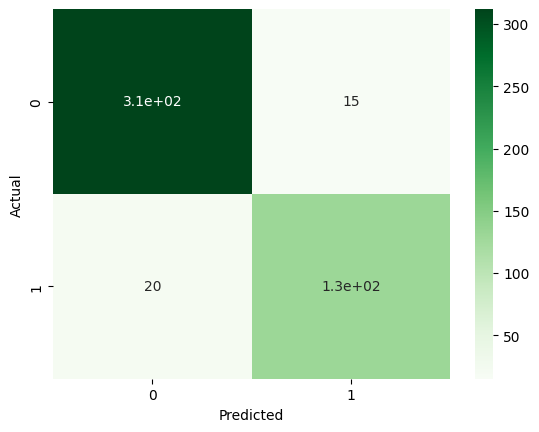

In [ ]:
cm = confusion_matrix(y_test, xgb_pred)
print(cm)
sns.heatmap(cm, annot = True, cmap = 'Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
xgb_report = classification_report(y_test, xgb_pred)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       327
           1       0.90      0.87      0.88       150

    accuracy                           0.93       477
   macro avg       0.92      0.91      0.91       477
weighted avg       0.93      0.93      0.93       477



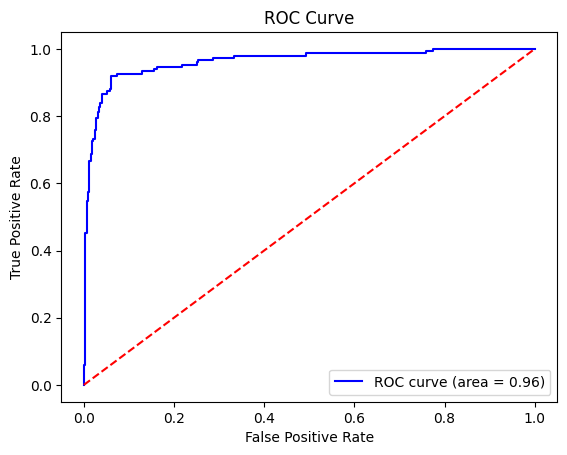

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, xgb_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color = 'Blue', label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color = 'Red', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Keeping track of the best accuracy, best recall and best model so far.

In [ ]:
prev_accuracy = best_accuracy
prev_recall = best_recall
prev_model = best_model
prev_params = best_params

In [ ]:
if f'{accuracy_score(y_test, xgb_pred):.2f}' > best_accuracy:
  best_accuracy = f'{accuracy_score(y_test, xgb_pred):.2f}'
if f'{recall_score(y_test, xgb_pred):.2f}' > best_recall:
  best_recall = f'{recall_score(y_test, xgb_pred):.2f}'

In [ ]:
if best_recall != prev_recall:
  best_model = xgb
  best_params = xgb.get_params()

In [ ]:
print('Best Accuracy so far: ', best_accuracy)
print('Best Recall so far: ', best_recall)
print('Best model so far: ', best_model)
print('Best Parameters so far: ', best_params)

Best Accuracy so far:  0.93
Best Recall so far:  0.92
Best model so far:  GradientBoostingClassifier()
Best Parameters so far:  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


### With Hyperparameter Tuning

#### First we will apply hyperparameter tuning on GradientBoostingClassifier and check the metrics.

In [ ]:
params = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'max_depth': [3, 5],
    'max_features': ['sqrt', 'log2']
}

gbm = GradientBoostingClassifier()
grid_search_tuned = GridSearchCV(estimator=gbm, param_grid=params, cv=5, n_jobs=-1)
grid_search_tuned.fit(X_train_bal, y_train_bal)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5], 'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]})

In [ ]:
best_gbm_tuned_params = grid_search_tuned.best_params_
best_gbm_tuned_score = grid_search_tuned.best_score_

In [ ]:
print(f'The best parameters of tuned model are: {best_gbm_tuned_params}')

The best parameters of tuned model are: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.8}


In [ ]:
final_gbm = GradientBoostingClassifier(
    learning_rate = 0.1,
    max_depth = 5,
    max_features = 'log2',
    n_estimators = 300,
    subsample = 1.0
)

cv_score_gbm = cross_val_score(final_gbm, X_train_bal, y_train_bal, cv = 5)
print(f'The cross validation score is: {cv_score_gbm}')
print(f'The mean of cross validation score is : {cv_score_gbm.mean()}')

The cross validation score is: [0.92635659 0.90310078 0.92635659 0.9592233  0.95145631]
The mean of cross validation score is : 0.9332987130277715


In [ ]:
final_gbm.fit(X_train_bal, y_train_bal)
y_pred_gbm_tuned = final_gbm.predict(X_Test)
y_prob_gbm_tuned = final_gbm.predict_proba(X_Test)[:, 1]

In [ ]:
print(f'Accuracy score is: {accuracy_score(y_test, y_pred_gbm_tuned):.2f}')
print(f'Precision of model is: {precision_score(y_test, y_pred_gbm_tuned):.2f}')
print(f'Recall value is : {recall_score(y_test, y_pred_gbm_tuned):.2f}')
print(f'F1 score is : {f1_score(y_test, y_pred_gbm_tuned):.2f}')

Accuracy score is: 0.92
Precision of model is: 0.88
Recall value is : 0.87
F1 score is : 0.88


[[310  17]
 [ 20 130]]


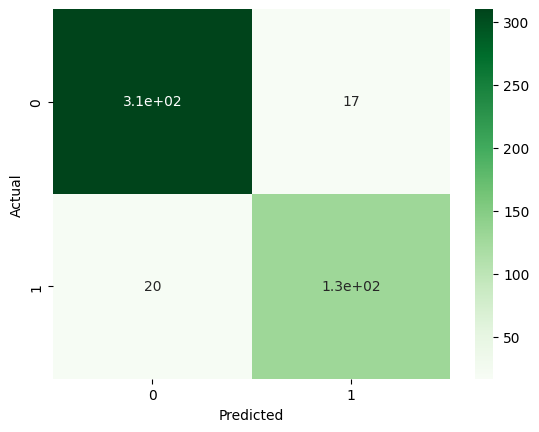

In [ ]:
cm = confusion_matrix(y_test, y_pred_gbm_tuned)
print(cm)
sns.heatmap(cm, annot = True, cmap = 'Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
gbm_tuned_report = classification_report(y_test, y_pred_gbm_tuned)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       327
           1       0.90      0.87      0.88       150

    accuracy                           0.93       477
   macro avg       0.92      0.91      0.91       477
weighted avg       0.93      0.93      0.93       477



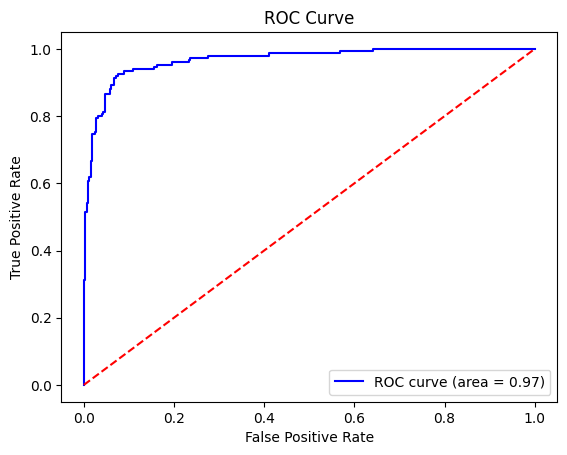

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gbm_tuned)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color = 'Blue', label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color = 'Red', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Keeping track of the best accuracy, best recall and best model so far.

In [ ]:
prev_accuracy = best_accuracy
prev_recall = best_recall
prev_model = best_model
prev_params = best_params

In [ ]:
if f'{accuracy_score(y_test, y_pred_gbm_tuned):.2f}' > best_accuracy:
  best_accuracy = f'{accuracy_score(y_test, y_pred_gbm_tuned):.2f}'
if f'{recall_score(y_test, y_pred_gbm_tuned):.2f}' > best_recall:
  best_recall = f'{recall_score(y_test, y_pred_gbm_tuned):.2f}'

In [ ]:
if best_recall != prev_recall:
  best_model = final_gbm
  best_params = final_gbm.get_params()

In [ ]:
print('Best Accuracy so far: ', best_accuracy)
print('Best Recall so far: ', best_recall)
print('Best model so far: ', best_model)
print('Best Parameters so far: ', best_params)

Best Accuracy so far:  0.93
Best Recall so far:  0.92
Best model so far:  GradientBoostingClassifier()
Best Parameters so far:  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


#### Now we will apply Hyperparameter tuning on XGBoost.

In [ ]:
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=params,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1,
)

grid_search_xgb.fit(X_train_bal, y_train_bal)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [ ]:
xgb_best_params = grid_search_xgb.best_params_
xgb_best_score = grid_search_xgb.best_score_

In [ ]:
print(f'The best parameters of tuned model are: {xgb_best_params}')

The best parameters of tuned model are: {'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 1.0}


In [ ]:
final_xgb = XGBClassifier(use_label_encoder=False,
    eval_metric='logloss',
    colsample_bytree = 0.6,
    gamma = 0.2,
    learning_rate = 0.1,
    max_depth = 7,
    min_child_weight = 3,
    n_estimators = 50,
    subsample = 1.0
)

cv_score_xgb_tuned = cross_val_score(final_xgb, X_train_bal, y_train_bal, cv = 5)
print(f'The cross validation score is: {cv_score_xgb_tuned}')
print(f'The mean of cross validation score is : {cv_score_xgb_tuned.mean()}')

The cross validation score is: [0.93604651 0.92635659 0.93604651 0.96116505 0.9592233 ]
The mean of cross validation score is : 0.9437675923835329


In [ ]:
final_xgb.fit(X_train_bal, y_train_bal)
y_pred_xgb_tuned = final_xgb.predict(X_Test)
y_prob_xgb_tuned = final_xgb.predict_proba(X_Test)[:, 1]

In [ ]:
print(f'Accuracy score is: {accuracy_score(y_test, y_pred_xgb_tuned):.2f}')
print(f'Precision of model is: {precision_score(y_test, y_pred_xgb_tuned):.2f}')
print(f'Recall value is : {recall_score(y_test, y_pred_xgb_tuned):.2f}')
print(f'F1 score is : {f1_score(y_test, y_pred_xgb_tuned):.2f}')

Accuracy score is: 0.94
Precision of model is: 0.90
Recall value is : 0.92
F1 score is : 0.91


[[312  15]
 [ 12 138]]


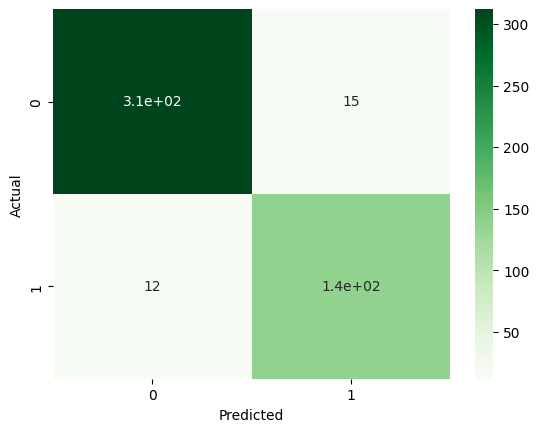

In [ ]:
cm = confusion_matrix(y_test, y_pred_xgb_tuned)
print(cm)
sns.heatmap(cm, annot = True, cmap = 'Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
xgb_tuned_report = classification_report(y_test, y_pred_xgb_tuned)
print(xgb_tuned_report)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       327
           1       0.90      0.92      0.91       150

    accuracy                           0.94       477
   macro avg       0.93      0.94      0.93       477
weighted avg       0.94      0.94      0.94       477



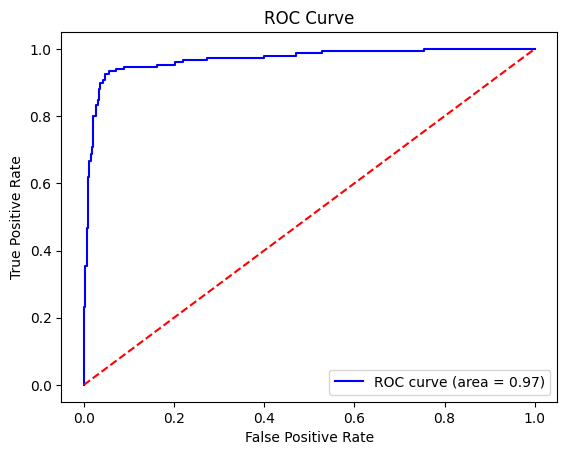

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_xgb_tuned)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color = 'Blue', label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color = 'Red', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Keeping track of the best accuracy, best recall and best model so far.

In [ ]:
prev_accuracy = best_accuracy
prev_recall = best_recall
prev_model = best_model
prev_params = best_params

In [ ]:
if f'{accuracy_score(y_test, y_pred_xgb_tuned):.2f}' > best_accuracy:
  best_accuracy = f'{accuracy_score(y_test, y_pred_xgb_tuned):.2f}'
if f'{recall_score(y_test, y_pred_xgb_tuned):.2f}' > best_recall:
  best_recall = f'{recall_score(y_test, y_pred_xgb_tuned):.2f}'

In [ ]:
if best_accuracy != prev_accuracy or best_recall != prev_recall:
  best_model = final_xgb
  best_params = final_xgb.get_params()

In [ ]:
print('Best Accuracy so far: ', best_accuracy)
print('Best Recall so far: ', best_recall)
print('Best model so far: ', best_model)
print('Best Parameters so far: ', best_params)

Best Accuracy so far:  0.94
Best Recall so far:  0.92
Best model so far:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)
Best Parameters so far:  {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsam

## **Analyzing Feature Importance of the best model**

In [ ]:
print(f'After analyzing models and doing hyperparameter tuning we find the best model is : ', best_model)

After analyzing models and doing hyperparameter tuning we find the best model is :  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)


We will now fit the data on this model and then analyze top features and their influence on model's predictions.

In [ ]:
best_model.fit(X_train_bal, y_train_bal)
y_best_predictions = best_model.predict(X_Test)
y_best_predictions_proba = best_model.predict_proba(X_Test)[:,1]

In [ ]:
booster = best_model.get_booster()
importance = booster.get_score(importance_type = 'weight')

In [ ]:
importance_df = pd.DataFrame(importance.items(), columns = ['Features', 'Importance'])
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)

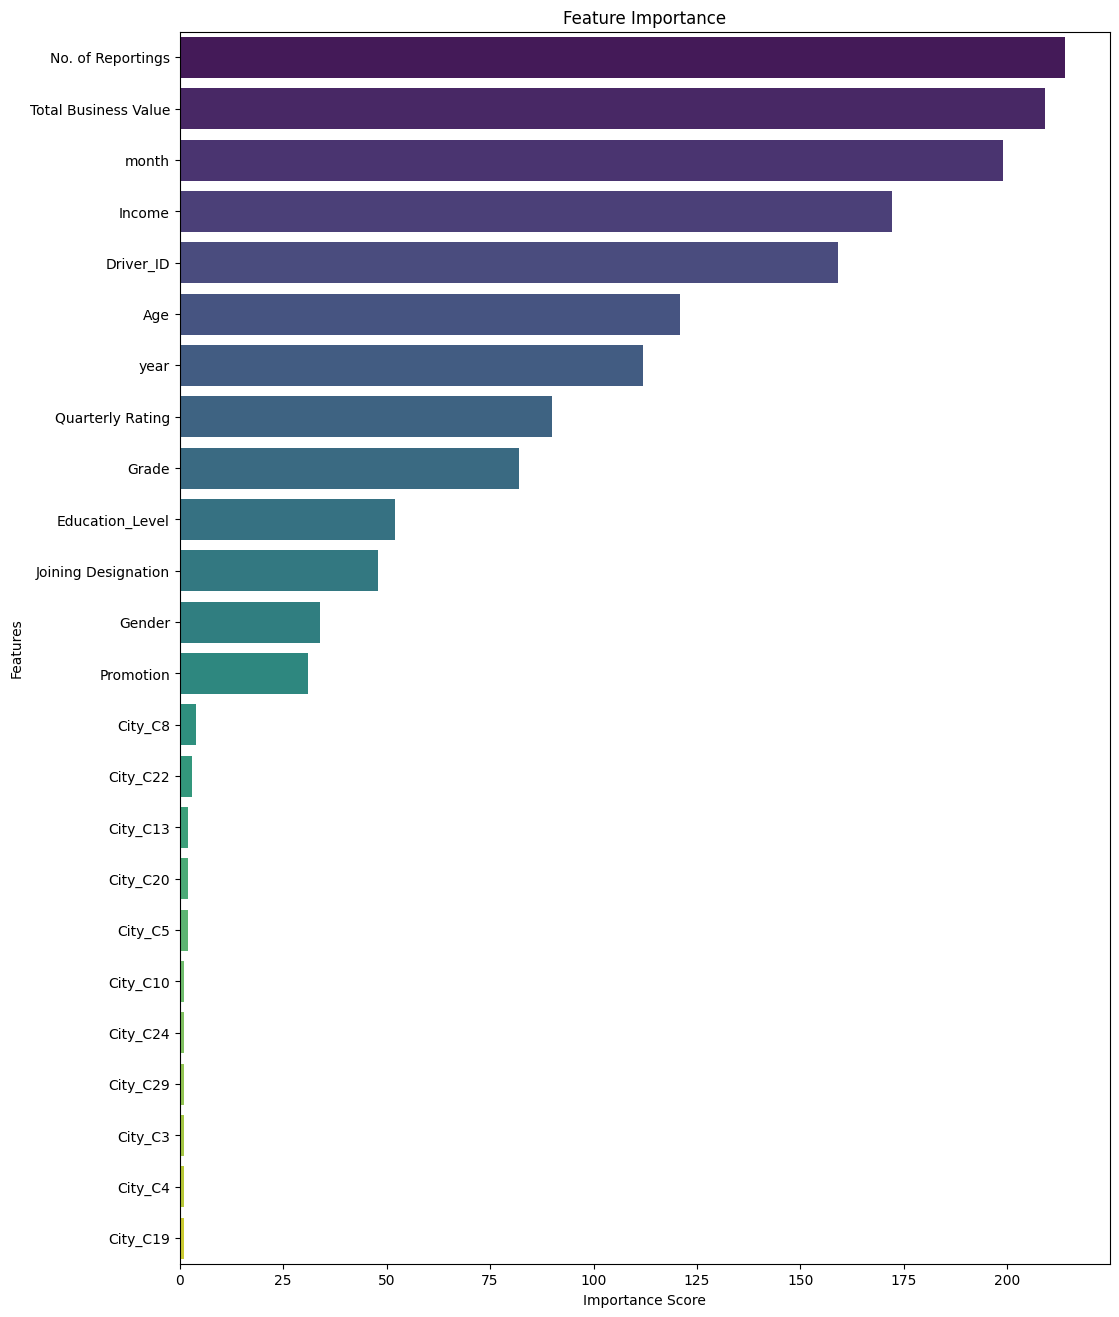

In [ ]:
plt.figure(figsize=(12, 16))
sns.barplot(x='Importance', y='Features', data=importance_df, palette = 'viridis')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# **Actionable Insights and Recommendations**

## **Insights**

1. So we see that there are 57% male employees and 43% female employees.
2. The percentages of employees with different education levels are almost same for level 1 & 2.
3. 97.3% of the employees who did not get a raise.
4. The percentage of drivers have received a quarterly rating of 5 is 0%.
5. The correlation between `Age` and `Quaterly Rating` is 0.207.
6. Drivers with grade `1` are likely to have higher Total Business Value - False. It is drivers with grade `3`.
7. From Ola's perspective, the best parameter to focus on for the company is Recall. This is because our goal is to reduce False Negatives because we don't want to missclassify a driver who will leave but the predicts that he will not leave.
8. There is no seasonality in the Ratings of drivers. It is maximum in the month of July and minimum in the month of December. Rest of the year it fluctuates a lot.
9. Yes, the driver's performance is affected by the city they operate in. The significant variations in average ratings suggest that factors unique to each city play a role in driver performance.
10. Besides `Number of Reportings` some important features are `Total Business Value` and `month`.

## **Recommendations**


1. Enhancing workforce gender diversity.
2. Developing training centres and educational institutes for the drivers in order to make sure that drivers are literate well enough for customers to trust them.
3. Company should address the lack of Raises of drivers.
4. There should be improvement in service quality such as condition of cars, time for driver to reach a customer, better UI for app, etc.
5. Company should also target cities and months where it can make maximum profit.
